# ASSIGNMENT 7 LOGISTIC REGRESSION

### Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import joblib

### Step 1: Data Exploration (EDA)

In [2]:
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

In [3]:
train.shape,test.shape

((891, 12), (418, 11))

In [4]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [6]:
print(train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [7]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


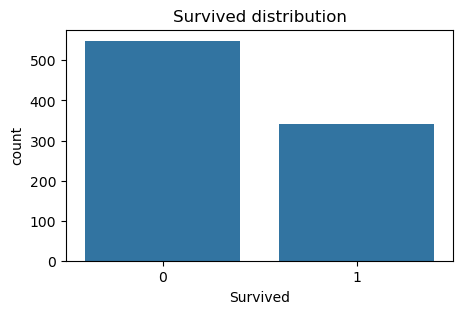

In [9]:
plt.figure(figsize=(5,3))
sns.countplot(x="Survived",data=train)
plt.title("Survived distribution")
plt.show()

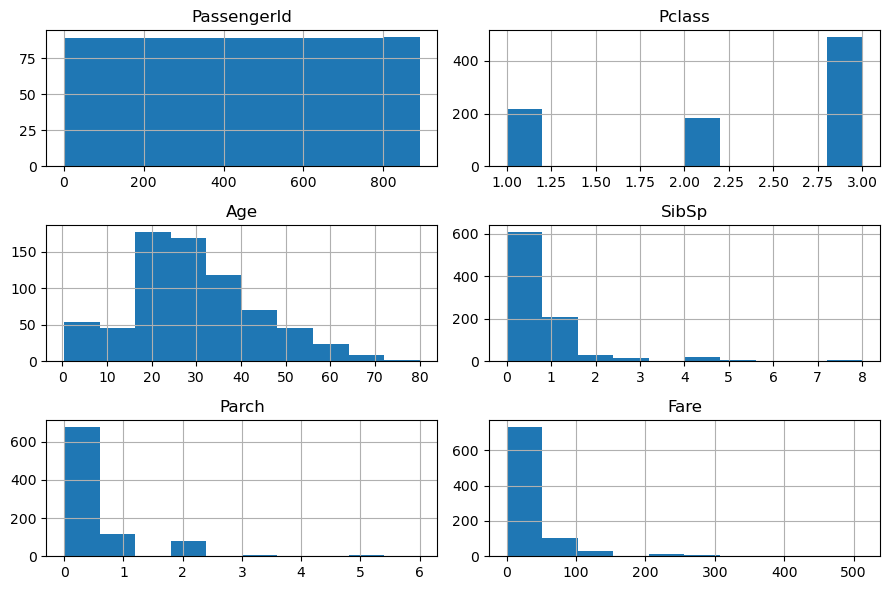

In [10]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if "Survived" in num_cols: num_cols.remove("Survived")
train[num_cols].hist(bins=10, figsize=(9,6))
plt.tight_layout()
plt.show()

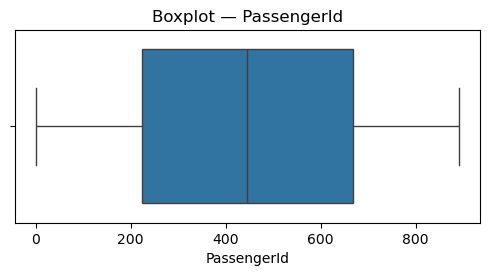

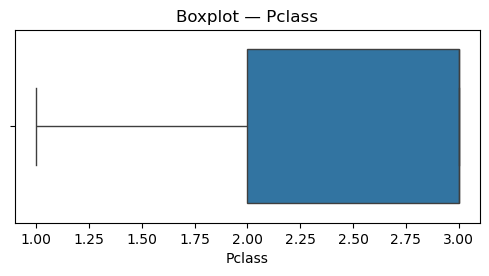

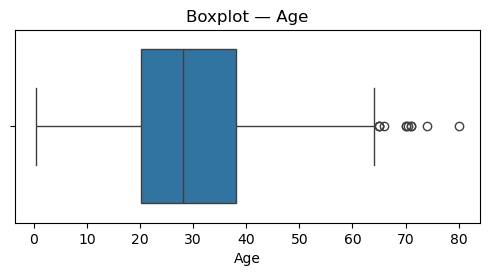

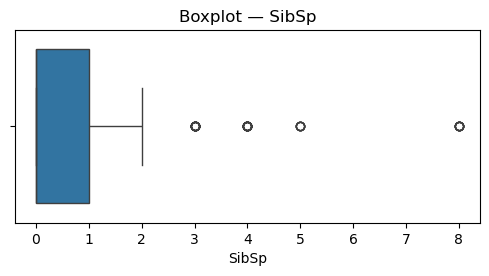

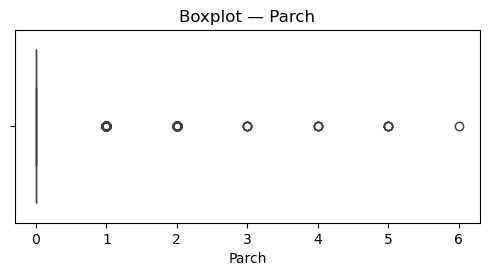

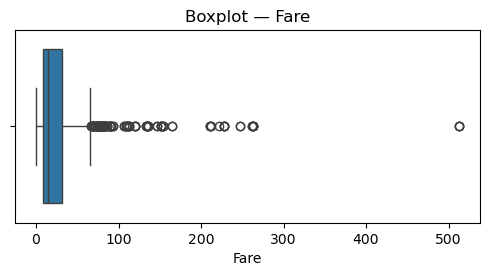

In [11]:
for c in num_cols:
    plt.figure(figsize=(6,2.5))
    sns.boxplot(x=train[c])
    plt.title(f"Boxplot — {c}")
    plt.show()

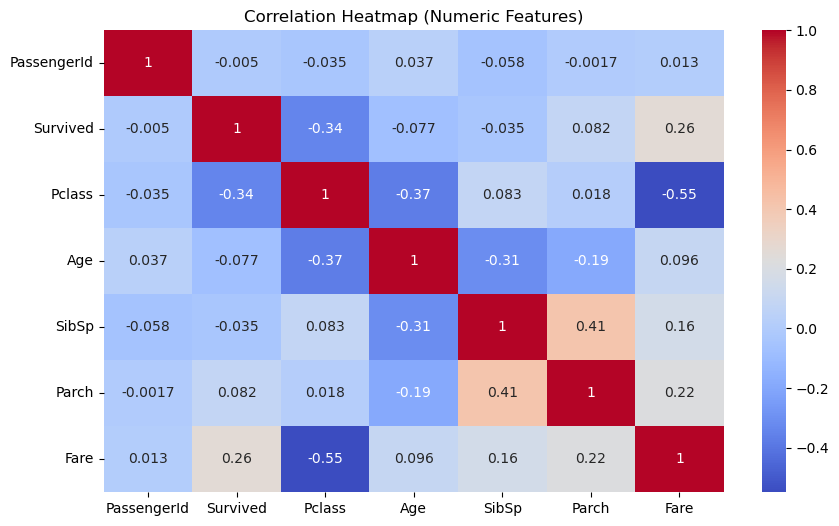

In [12]:
numeric_cols = train.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

### Step 2: Data Proprocessing

In [13]:
# ==== TRAIN DATASET ====
# fill Age with median
train["Age"] = train["Age"].fillna(train["Age"].median())    
# fill Embarked with mode
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])  
# drop Cabin (too many missing)
train = train.drop(columns=["Cabin"])  

In [14]:
# ==== TEST DATASET MISSING VALUES ====
# Fill Age with train median (we already did earlier, just keeping consistent)
test["Age"] = test["Age"].fillna(train["Age"].median())
# Fill Fare (only 1 missing) with train median
test["Fare"] = test["Fare"].fillna(train["Fare"].median())
# Drop Cabin (too many missing)
test = test.drop(columns=["Cabin"])

In [15]:
le_sex = LabelEncoder()
le_embarked = LabelEncoder()

In [16]:
# Fit on TRAIN only, then transform both TRAIN and TEST
train["Sex"] = le_sex.fit_transform(train["Sex"])
test["Sex"] = le_sex.transform(test["Sex"])

In [17]:
train["Embarked"] = le_embarked.fit_transform(train["Embarked"])
test["Embarked"] = le_embarked.transform(test["Embarked"])

In [18]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X_train = train[features]
y_train = train["Survived"]

X_test  = test[features]

### Step 3: Logistic Regression Model

In [19]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train,y_train)


LogisticRegression(max_iter=500)

In [20]:
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

### Step 4: Model Evalution

In [21]:
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.8,random_state=42)

In [22]:
# Train again on training split
log_reg.fit(X_tr, y_tr)

LogisticRegression(max_iter=500)

In [23]:
# Predict on validation set
y_val_pred = log_reg.predict(X_val)

In [24]:
# Evaluation metrics
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 Score :", f1_score(y_val, y_val_pred))

Accuracy : 0.7994389901823282
Precision: 0.7913043478260869
Recall   : 0.6570397111913358
F1 Score : 0.717948717948718


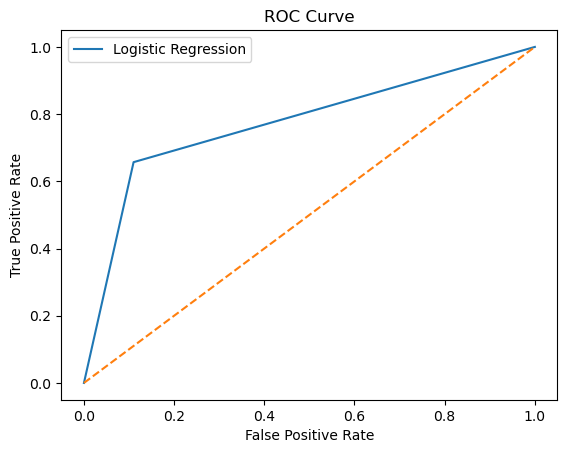

In [25]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Step 5: Interpretation

In [26]:
coefficients = pd.DataFrame({
    "Feature":X_train.columns,
    "Coefficient":log_reg.coef_[0]
}).sort_values(by="Coefficient",ascending=False)
print(coefficients)

    Feature  Coefficient
5      Fare    -0.002117
2       Age    -0.018469
3     SibSp    -0.032119
4     Parch    -0.371163
6  Embarked    -0.388535
0    Pclass    -1.041079
1       Sex    -2.625143


### Step 6: Deployment with streamlit 

In [27]:
joblib.dump(log_reg,"titanic_model.pkl")

['titanic_model.pkl']

In [28]:
import streamlit as st

In [29]:
model = joblib.load("titanic_model.pkl")

In [30]:
st.title("Titanic Survival Prediction App")

2025-09-26 12:30:53.575 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 12:30:54.545 
  command:

    streamlit run E:\Anaconda\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-26 12:30:54.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [31]:
st.write("Enter passenger details below and check survival prediction:")

2025-09-26 12:30:54.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 12:30:54.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


#### Interview Questions

**Q1. What is the difference between precision and recall?**

Precision = Out of all predicted positives, how many are actually positive. (Focus: quality of positive predictions)

Recall = Out of all actual positives, how many did we correctly predict. (Focus: finding all positives)

Example:
Spam filter → High precision means very few non-spam emails marked as spam.
High recall means catching almost all spam emails, even if some normal mails are marked as spam.

**Q2. What is cross-validation, and why is it important in binary classification?**

Cross-validation splits training data into multiple folds (e.g., 5 or 10), trains model on some folds, validates on others, and averages performance.

It helps to:
Avoid overfitting
Get a more reliable estimate of model performance
Ensure model generalizes well to unseen data